In [1]:
# Dataframe
import pandas as pd

# Array
import numpy as np
import ast

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline

# Datetime
from datetime import datetime

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Large dataset
import dask.bag as db

# STRINGS
import re

# Sentiment
import glob
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import string
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings("ignore") ## TO AVOID SettingWithCopyWarning

In [4]:
##########################################
## IMPORT PRODUCT REVIEW DATA IN PANDAS
##########################################
review_df = pd.read_csv(r'amazon-reviews/reviews_Clothing_Shoes_and_Jewelry_5.csv')

##########################################
## CHECK PRODUCT DATA IN PANDAS
##########################################
# change column name 
review_df = review_df.rename(columns={'overall': 'Rating'})

print ("Total data:", str(review_df.shape))
review_df.head()

Total data: (278677, 10)


,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,Rating,summary,unixReviewTime,reviewTime
0,0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"
3,3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014"


In [7]:
##########################################
# CHECKING DUPLICATES
##########################################
review_df[review_df.duplicated(['reviewerID','asin','reviewerName','unixReviewTime'], keep= False)]

,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,Rating,summary,unixReviewTime,reviewTime


In [6]:
##########################################
## CHECKING FOR MISSING VALUES
##########################################
review_df.isnull().sum()

Unnamed: 0          0
reviewerID          0
asin                0
reviewerName      469
helpful             0
reviewText         24
Rating              0
summary             1
unixReviewTime      0
reviewTime          0
dtype: int64

In [12]:
##########################################
## DATA TRANSFORMATION
##########################################
review_df['reviewDate']=pd.to_datetime(review_df['unixReviewTime'],unit='s')                    ## TO DATE
review_df['reviewYear']=review_df['reviewDate'].dt.year                                         ## TO YEAR
review_df['reviewMonth']=review_df['reviewDate'].dt.month                                       ## TO MONTH
review_df['reviewWeekday']=review_df['reviewDate'].dt.weekday                                   ## TO DAY OF THE WEEK
review_df['positiveVote']=review_df['helpful'].apply(lambda x:int(x[1:-1].split(",")[0]))       ## SUBSTRACT POSITIVE VOTES #### GOT HELP WITH THIS ONE
review_df['totalVote']=review_df['helpful'].apply(lambda x:int(x[1:-1].split(",")[1]))          ## SUBSTRACT ALL VOTES      #### GOT HELP WITH THIS ONE
review_df['totalVote_flag']=['No Votes' if x == 0 else 'Votes' for x in review_df['totalVote']] ## FLAG TO FILTER REVIEWS WITHOUT VOTES
review_df['totalVote_score']=(review_df['positiveVote']/review_df['totalVote']).fillna(0)*100   ## SHARE OF POSITIVE VOTES
review_df['characterLength']=review_df['reviewText'].fillna('0').apply(lambda x: len(x))        ## COUNT ALL CHARACTERS IN THE REVIEW
review_df['wordLength']=review_df['reviewText'].fillna('0').apply(lambda x: len(x.split()))     ## COUNT ALL WORDS IN THE REVIEW

##########################################
## SENTIMENT ANALYSES -- TAKING A LOT OF TIME BUT IT IS IMPORTANT
##########################################

def NaiveBaiyes_Sentimental(sentence):
    blob = TextBlob(sentence, analyzer=NaiveBayesAnalyzer())
    NaiveBayes_SentimentScore=blob.sentiment.classification
    return NaiveBayes_SentimentScore

# VADER sentiment analysis tool for getting Compound score.
def sentimental(sentence):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(sentence)
    score=vs['compound']
    return score

# VADER sentiment analysis tool for getting pos, neg and neu.
def sentimental_Score(sentence):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(sentence)
    score=vs['compound']
    if score >= 0.5:
        return 'pos'
    elif (score > -0.5) and (score < 0.5):
        return 'neu'
    elif score <= -0.5:
        return 'neg'

review_df['sentimentScore_flag']=review_df['reviewText'].fillna('0').apply(lambda x: sentimental_Score(x)) ## GROUPED SENTIMENT SCORE
review_df['sentimentScore']=review_df['reviewText'].fillna('0').apply(lambda x: sentimental(x))            ## ACTUAL SENTIMENT SCORE

review_df.head()

,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,Rating,summary,unixReviewTime,reviewTime,...,reviewMonth,reviewWeekday,positiveVote,totalVote,totalVote_flag,totalVote_score,characterLength,wordLength,sentimentScore,sentimentScore_flag
0,0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011",...,2,5,0,0,No Votes,0.0,172,35,0.9332,pos
1,1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013",...,1,5,0,0,No Votes,0.0,306,61,0.9348,pos
2,2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013",...,1,4,0,0,No Votes,0.0,312,62,0.9818,pos
3,3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014",...,4,6,0,0,No Votes,0.0,405,76,0.6614,pos
4,4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014",...,3,5,0,0,No Votes,0.0,453,80,0.9869,pos


In [ ]:
review_df.to_csv('review_df.csv')

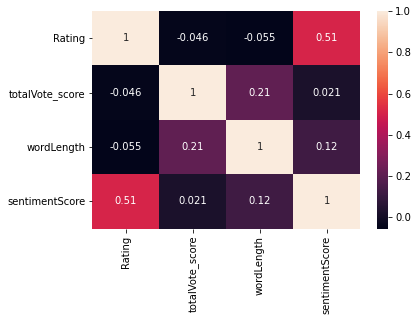

In [2]:
##########################################
## IMPORT PRODUCT REVIEW DATA IN PANDAS
##########################################
review_df_c = pd.read_csv(r'review_df.csv')

##########################################
## CORRELATION MATRIX
##########################################
df_correl = pd.DataFrame(review_df_c,columns=['Rating','totalVote_score','wordLength','sentimentScore'])
#print (df_correl)
corrMatrix = df_correl.corr()
#print (corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

totalVote_flag,No Votes,Votes
Rating,,
1.0,5197,5995
2.0,9043,6420
3.0,19755,10670
4.0,41057,17300
5.0,116604,46636


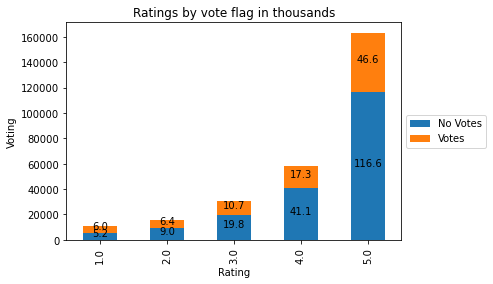

In [117]:
##########################################
## DISTRIBUTION OF REVIEWS WITH VOTES
##########################################
df_grouped = review_df_c.groupby(['Rating','totalVote_flag']).count()['totalVote'].unstack()
my_plot = df_grouped.plot(kind='bar',stacked=True,title="Ratings by vote flag in thousands")
my_plot.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
my_plot.set_xlabel("Rating")
my_plot.set_ylabel("Voting")
for p in my_plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    my_plot.annotate(f'{(height/1000).round(1)}', (x + width/2, y + height*0.5), ha='center', rotation=0, fontweight='bold')
df_grouped

totalVote_flag,No Votes,Votes
Rating,,
1.0,0.464350,0.535650
2.0,0.584815,0.415185
3.0,0.649302,0.350698
4.0,0.703549,0.296451
5.0,0.714310,0.285690


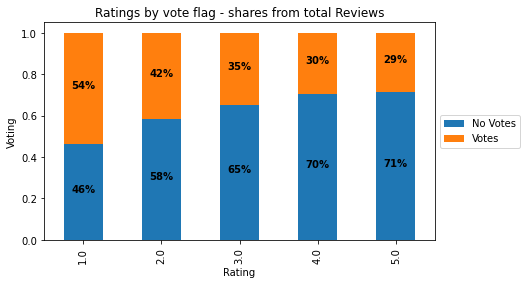

In [205]:
freq_df = review_df_c.groupby(['Rating','totalVote_flag']).count()['totalVote'].unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)
my_plot = pct_df.plot(kind="bar", stacked=True, title="Ratings by vote flag - shares from total Reviews")
my_plot.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
my_plot.set_xlabel("Rating")
my_plot.set_ylabel("Voting")
# loop to add the annotations
for p in my_plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    my_plot.annotate(f'{height:.0%}', (x + width/2, y + height*0.5), ha='center', fontweight='bold')
pct_df

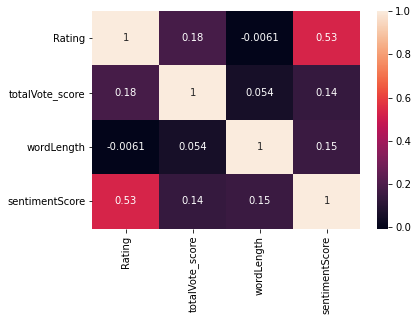

In [17]:
##########################################
## CORRELATION MATRIX - ONLY FOR REVIEWS WITH VOTES
##########################################
df_correl_excl = pd.DataFrame(review_df_c[review_df_c['totalVote_flag'] == 'Votes'],columns=['Rating','totalVote_score','wordLength','sentimentScore'])
#print (df_correl)
corrMatrix = df_correl_excl.corr()
#print (corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

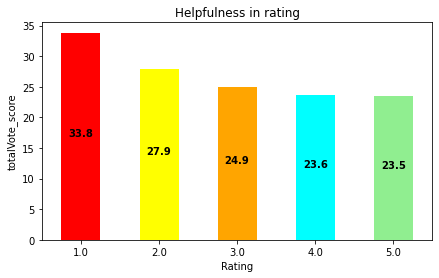

<Figure size 72x72 with 0 Axes>

In [214]:
##########################################
## DISTRIBUTION OF RATING FOR HELPFULNESS
########################################## 
my_plot = review_df_c.groupby('Rating')['totalVote_score'].mean().plot(kind='bar', color=['red', 'yellow', 'orange', 'cyan', 'lightgreen']) 
plt.title("Helpfulness in rating")
plt.xlabel("Rating")
plt.ylabel("totalVote_score")
plt.xticks(rotation=0)
# loop to add the annotations
for p in my_plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    my_plot.annotate(f'{height.round(1)}', (x + width/2, y + height*0.5), ha='center', rotation=0, color = 'black', fontweight='bold')

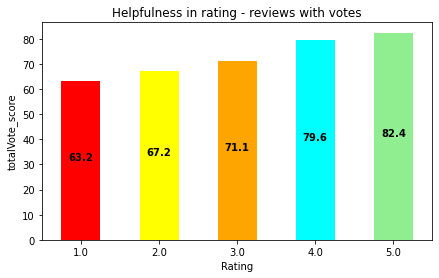

In [211]:
##########################################
## DISTRIBUTION OF RATING FOR HELPFULNESS - ONLY FOR REVIEWS WITH VOTES
########################################## 
my_plot = review_df_c[review_df_c['totalVote_flag'] == 'Votes'].groupby('Rating')['totalVote_score'].mean().plot(kind='bar', color=['red', 'yellow', 'orange', 'cyan', 'lightgreen']) 
plt.title("Helpfulness in rating - reviews with votes")
plt.xlabel("Rating")
plt.ylabel("totalVote_score")
plt.xticks(rotation=0)
# loop to add the annotations
for p in my_plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    my_plot.annotate(f'{height.round(1)}', (x + width/2, y + height*0.5), ha='center', rotation=0, color = 'black', fontweight='bold')

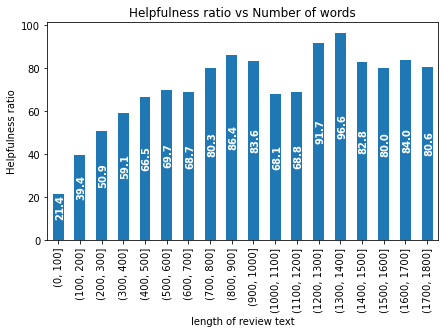

<Figure size 1152x432 with 0 Axes>

In [215]:
my_plot = review_df_c.groupby(pd.cut(review_df_c['wordLength'], np.arange(0,1805,100)))['totalVote_score'].mean().plot(kind='bar')
plt.xlabel("length of review text")
plt.ylabel("Helpfulness ratio")
plt.title("Helpfulness ratio vs Number of words")
# loop to add the annotations
for p in my_plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    my_plot.annotate(f'{height.round(1)}', (x + width/1.5, y + height*0.5), ha='center', rotation=90, color = 'white', fontweight='bold')


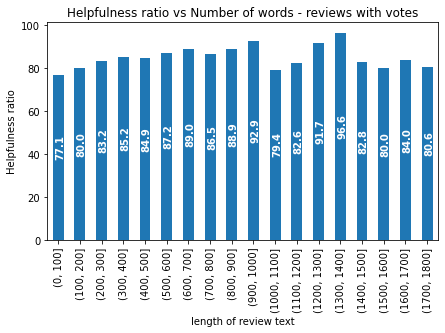

In [216]:

my_plot = review_df_c[review_df_c['totalVote_flag'] == 'Votes'].groupby(pd.cut(review_df_c[review_df_c['totalVote_flag'] == 'Votes']['wordLength'], np.arange(0,1805,100)))['totalVote_score'].mean().plot(kind='bar')
plt.xlabel("length of review text")
plt.ylabel("Helpfulness ratio")
plt.title("Helpfulness ratio vs Number of words - reviews with votes")
# loop to add the annotations
for p in my_plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    my_plot.annotate(f'{height.round(1)}', (x + width/1.5, y + height*0.5), ha='center', rotation=90, color = 'white', fontweight='bold')


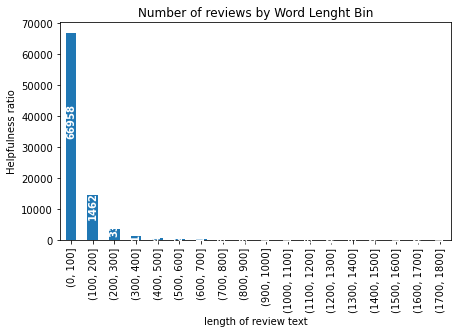

In [217]:

my_plot = review_df_c[review_df_c['totalVote_flag'] == 'Votes'].groupby(pd.cut(review_df_c[review_df_c['totalVote_flag'] == 'Votes']['wordLength'], np.arange(0,1805,100)))['reviewerID'].count().plot(kind='bar')
plt.xlabel("length of review text")
plt.ylabel("Helpfulness ratio")
plt.title("Number of reviews by Word Lenght Bin")
# loop to add the annotations
for p in my_plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    my_plot.annotate(f'{height.round(1)}', (x + width/2, y + height*0.5), ha='center', rotation=90, color = 'white', fontweight='bold')

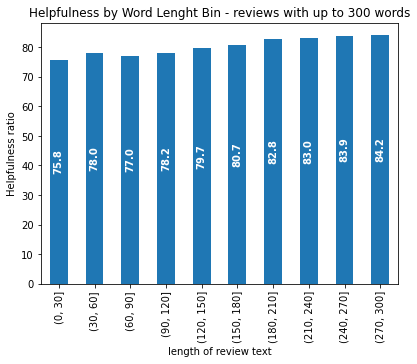

In [243]:
my_plot = review_df_c[(review_df_c['totalVote_flag'] == 'Votes') & (review_df_c['wordLength'] <= 300)].groupby(pd.cut(
review_df_c[(review_df_c['totalVote_flag'] == 'Votes') & (review_df_c['wordLength'] <= 300)]['wordLength'], np.arange(0,301,30)))['totalVote_score'].mean().plot(kind='bar') 
plt.xlabel("length of review text")
plt.ylabel("Helpfulness ratio")
plt.title("Helpfulness by Word Lenght Bin - reviews with up to 300 words")

#plt.rcParams['figure.figsize'] = [12, 6]
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault["figure.figsize"]
# loop to add the annotations
for p in my_plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    my_plot.annotate(f'{height.round(1)}', (x + width/2, y + height*0.5), ha='center', rotation=90, color = 'white', fontweight='bold')


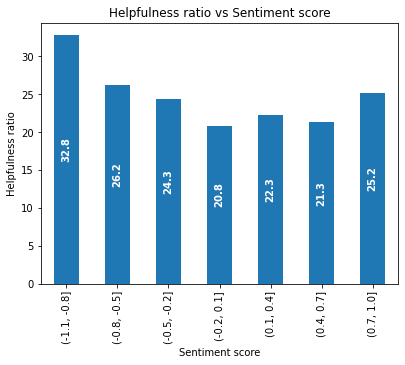

In [244]:

my_plot = review_df_c.groupby(pd.cut(review_df_c['sentimentScore'], np.arange(-1.1,1.1,0.3)))['totalVote_score'].mean().plot(kind='bar')
plt.xlabel("Sentiment score")
plt.ylabel("Helpfulness ratio")
plt.title("Helpfulness ratio vs Sentiment score")
# loop to add the annotations
for p in my_plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    my_plot.annotate(f'{height.round(1)}', (x + width/2, y + height*0.5), ha='center', rotation=90, color = 'white', fontweight='bold')


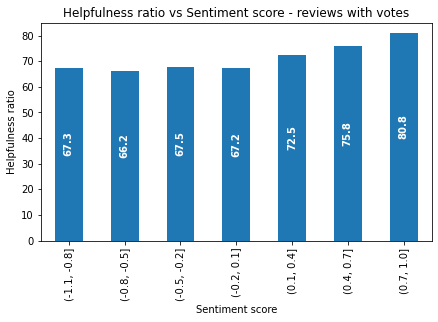

In [224]:

my_plot = review_df_c[review_df_c['totalVote_flag'] == 'Votes'].groupby(pd.cut(review_df_c[review_df_c['totalVote_flag'] == 'Votes']['sentimentScore'], np.arange(-1.1,1.1,0.3)))['totalVote_score'].mean().plot(kind='bar')
plt.xlabel("Sentiment score")
plt.ylabel("Helpfulness ratio")
plt.title("Helpfulness ratio vs Sentiment score - reviews with votes")
# loop to add the annotations
for p in my_plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    my_plot.annotate(f'{height.round(1)}', (x + width/2, y + height*0.5), ha='center', rotation=90, color = 'white', fontweight='bold')

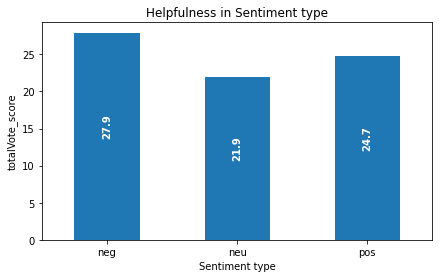

In [225]:

my_plot = review_df_c.groupby('sentimentScore_flag')['totalVote_score'].mean().plot(kind='bar') 
plt.title("Helpfulness in Sentiment type")
plt.xlabel("Sentiment type")
plt.ylabel("totalVote_score")
plt.xticks(rotation=0)
#plt.show()
# loop to add the annotations
for p in my_plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    my_plot.annotate(f'{height.round(1)}', (x + width/2, y + height*0.5), ha='center', rotation=90, color = 'white', fontweight='bold')

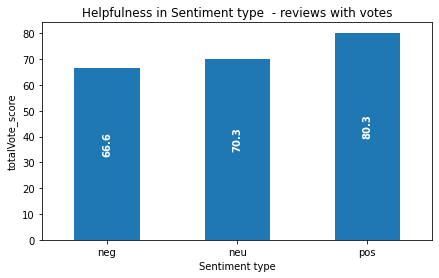

In [226]:

my_plot = review_df_c[review_df_c['totalVote_flag'] == 'Votes'].groupby('sentimentScore_flag')['totalVote_score'].mean().plot(kind='bar') 
plt.title("Helpfulness in Sentiment type  - reviews with votes")
plt.xlabel("Sentiment type")
plt.ylabel("totalVote_score")
plt.xticks(rotation=0)
# loop to add the annotations
for p in my_plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    my_plot.annotate(f'{height.round(1)}', (x + width/2, y + height*0.5), ha='center', rotation=90, color = 'white', fontweight='bold')

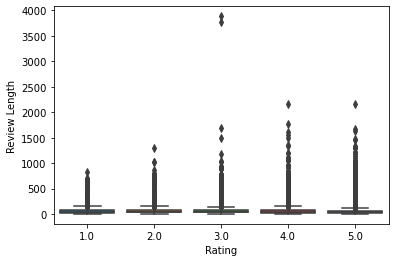

In [60]:

sns.boxplot(x='Rating',y='wordLength',data=review_df_c)
plt.xlabel('Rating')
plt.ylabel('Review Length')
plt.show()

In [41]:
AvgRatingProd_all =  review_df_c.groupby('asin',as_index=False).agg({'Rating':'mean',
                                                                     'totalVote_score':'mean',
                                                                     'wordLength':'mean',
                                                                     'sentimentScore':'mean',
                                                                     'reviewerID':'count',
                                                                     'positiveVote':'sum',
                                                                     'totalVote':'sum'
                                                                   })
AvgRatingProd_all

#sns.pairplot(AvgRatingProd_all,size=3) ##BELOW CHECKED ONLY FEW OF THE RELATIONS
#plt.show()

,asin,Rating,totalVote_score,wordLength,sentimentScore,reviewerID,positiveVote,totalVote
0,0000031887,4.608696,10.326087,52.652174,0.787548,23,9,11
1,0123456479,4.166667,25.000000,66.666667,0.781650,6,2,4
2,1608299953,4.307692,68.305936,219.000000,0.793538,13,361,393
3,1617160377,4.625000,55.015244,392.312500,0.927100,16,74,81
4,B00001W0KA,4.625000,6.250000,91.125000,0.817575,8,2,4
...,...,...,...,...,...,...,...,...
23028,B00KA602SY,3.833333,0.000000,23.166667,0.627183,6,0,1
23029,B00KCWMG5S,2.400000,40.000000,38.000000,0.201060,5,3,3
23030,B00KF9180W,4.800000,78.797619,193.700000,0.857980,10,32,42
23031,B00KGCLROK,4.400000,40.000000,130.800000,0.582980,5,2,2


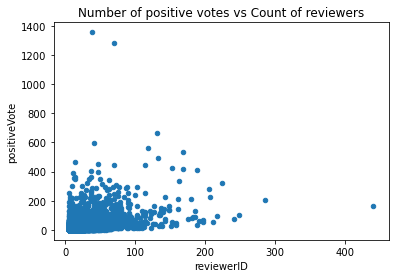

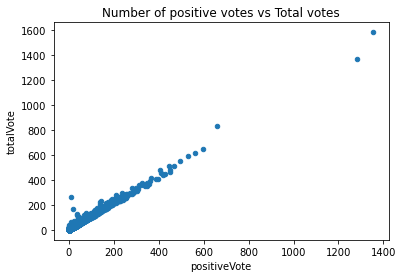

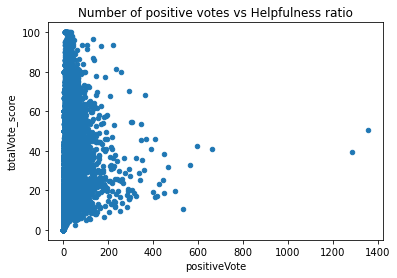

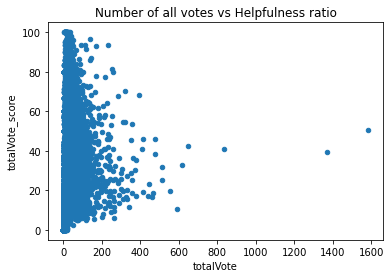

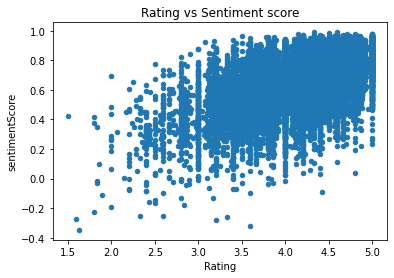

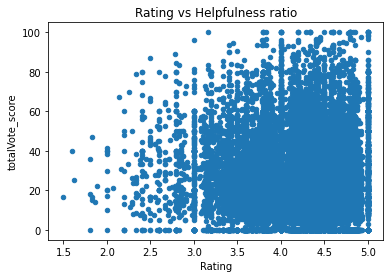

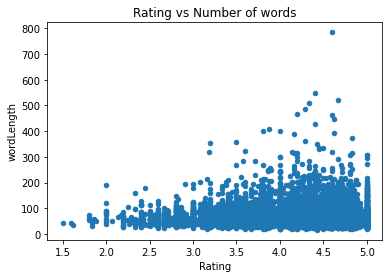

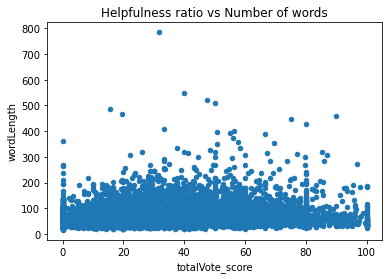

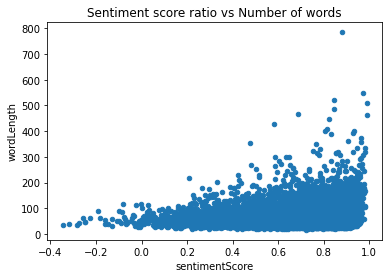

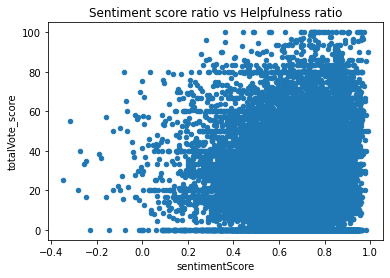

In [161]:
AvgRatingProd_all.plot(x="reviewerID",y="positiveVote",kind="scatter",title="Number of positive votes vs Count of reviewers")
AvgRatingProd_all.plot(x="positiveVote",y="totalVote",kind="scatter",title="Number of positive votes vs Total votes")
AvgRatingProd_all.plot(x="positiveVote",y="totalVote_score",kind="scatter",title="Number of positive votes vs Helpfulness ratio")
AvgRatingProd_all.plot(x="totalVote",y="totalVote_score",kind="scatter",title="Number of all votes vs Helpfulness ratio")
AvgRatingProd_all.plot(x="Rating",y="sentimentScore",kind="scatter",title="Rating vs Sentiment score")
AvgRatingProd_all.plot(x="Rating",y="totalVote_score",kind="scatter",title="Rating vs Helpfulness ratio")
AvgRatingProd_all.plot(x="Rating",y="wordLength",kind="scatter",title="Rating vs Number of words")
AvgRatingProd_all.plot(x="totalVote_score",y="wordLength",kind="scatter",title="Helpfulness ratio vs Number of words")
AvgRatingProd_all.plot(x="sentimentScore",y="wordLength",kind="scatter",title="Sentiment score ratio vs Number of words")
AvgRatingProd_all.plot(x="sentimentScore",y="totalVote_score",kind="scatter",title="Sentiment score ratio vs Helpfulness ratio")
#sns.pairplot(AvgRatingProd_all,size=3)
plt.show()

In [35]:
AvgRatingProd_votes =  review_df_c[review_df_c['totalVote_flag'] == 'Votes'].groupby('asin',as_index=False).agg({'Rating':'mean',
                                                                                                                 'totalVote_score':'mean',
                                                                                                                 'wordLength':'mean',
                                                                                                                 'sentimentScore':'mean',
                                                                                                                 'reviewerID':'count',
                                                                                                                 'positiveVote':'sum',
                                                                                                                 'totalVote':'sum'
                                                                                                                })
AvgRatingProd_votes

,asin,Rating,totalVote_score,wordLength,sentimentScore,reviewerID,positiveVote,totalVote
0,0000031887,4.666667,79.166667,70.666667,0.939133,3,9,11
1,0123456479,5.000000,50.000000,48.000000,0.948333,3,2,4
2,1608299953,4.250000,73.998097,209.750000,0.777542,12,361,393
3,1617160377,4.636364,80.022173,486.636364,0.903964,11,74,81
4,B00001W0KA,4.000000,50.000000,208.000000,0.992500,1,2,4
...,...,...,...,...,...,...,...,...
21213,B00KA602SY,5.000000,0.000000,23.000000,0.829400,1,0,1
21214,B00KCWMG5S,2.500000,100.000000,39.500000,0.630500,2,3,3
21215,B00KF9180W,4.800000,78.797619,193.700000,0.857980,10,32,42
21216,B00KGCLROK,3.500000,100.000000,199.000000,0.060850,2,2,2


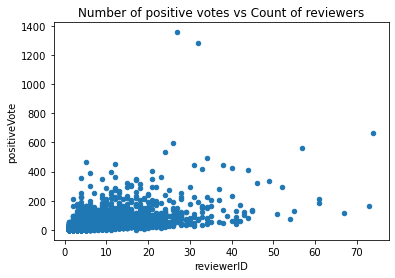

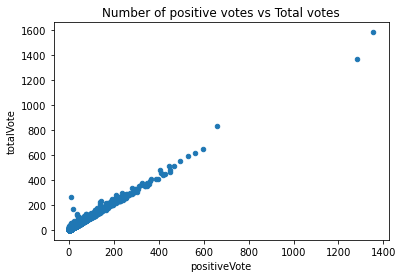

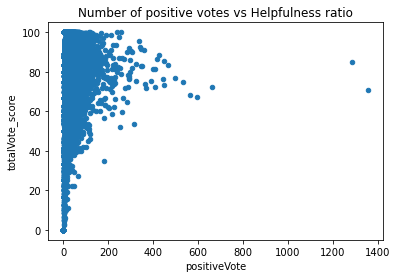

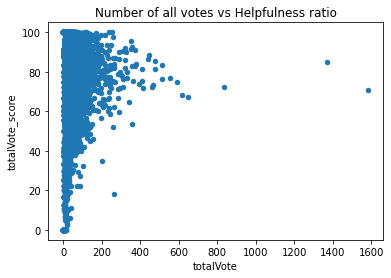

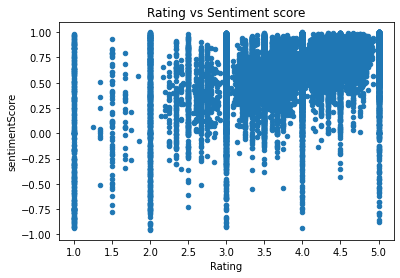

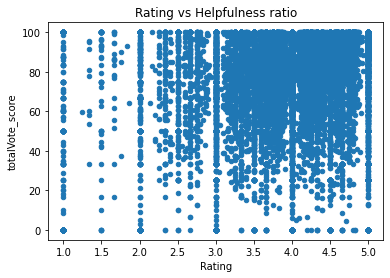

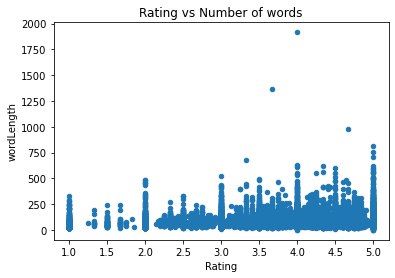

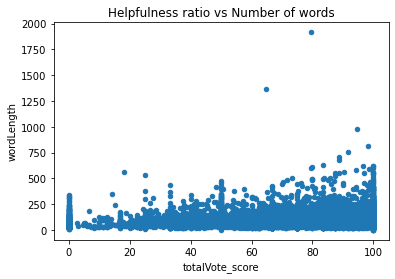

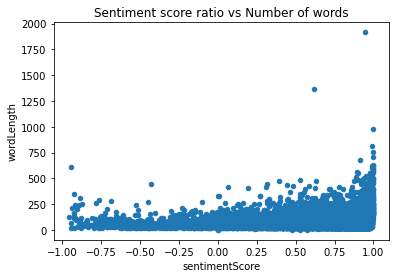

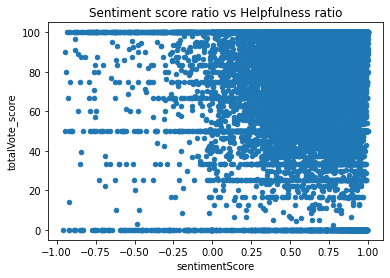

In [50]:
## STRANGE OUTLIERS IDENTIFIED - FILTERED totalVote_score > 100
AvgRatingProd_votes[AvgRatingProd_votes['totalVote_score'] <= 100].plot(x="reviewerID",y="positiveVote",kind="scatter",title="Number of positive votes vs Count of reviewers")
AvgRatingProd_votes[AvgRatingProd_votes['totalVote_score'] <= 100].plot(x="positiveVote",y="totalVote",kind="scatter",title="Number of positive votes vs Total votes")
AvgRatingProd_votes[AvgRatingProd_votes['totalVote_score'] <= 100].plot(x="positiveVote",y="totalVote_score",kind="scatter",title="Number of positive votes vs Helpfulness ratio")
AvgRatingProd_votes[AvgRatingProd_votes['totalVote_score'] <= 100].plot(x="totalVote",y="totalVote_score",kind="scatter",title="Number of all votes vs Helpfulness ratio")

AvgRatingProd_votes[AvgRatingProd_votes['totalVote_score'] <= 100].plot(x="Rating",y="sentimentScore",kind="scatter",title="Rating vs Sentiment score")
AvgRatingProd_votes[AvgRatingProd_votes['totalVote_score'] <= 100].plot(x="Rating",y="totalVote_score",kind="scatter",title="Rating vs Helpfulness ratio")
AvgRatingProd_votes[AvgRatingProd_votes['totalVote_score'] <= 100].plot(x="Rating",y="wordLength",kind="scatter",title="Rating vs Number of words")
AvgRatingProd_votes[AvgRatingProd_votes['totalVote_score'] <= 100].plot(x="totalVote_score",y="wordLength",kind="scatter",title="Helpfulness ratio vs Number of words")
AvgRatingProd_votes[AvgRatingProd_votes['totalVote_score'] <= 100].plot(x="sentimentScore",y="wordLength",kind="scatter",title="Sentiment score ratio vs Number of words")
AvgRatingProd_votes[AvgRatingProd_votes['totalVote_score'] <= 100].plot(x="sentimentScore",y="totalVote_score",kind="scatter",title="Sentiment score ratio vs Helpfulness ratio")
#sns.pairplot(AvgRatingProd_all,size=3)
plt.show()